In [1]:
import pandas as pd
import numpy as np
from tqdm import tqdm
import os
import matplotlib.pyplot as plt
import seaborn as sns

import sklearn
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold

from tensorflow import keras
from keras.models import Sequential
from keras import Input
from keras.layers import Dense
from tensorflow.keras.callbacks import ModelCheckpoint
from keras.models import load_model
from keras.callbacks import EarlyStopping

from lightgbm import LGBMRegressor
import random
import xgboost as xgb

In [2]:
import warnings
warnings.filterwarnings("ignore")

import tensorflow as tf

from tensorflow.keras.layers import LSTM 
from tensorflow.keras.models import Sequential 
from tensorflow.keras.layers import Dense, SimpleRNN, GRU
import keras.backend as K 
from keras.callbacks import EarlyStopping
from sklearn.preprocessing import MinMaxScaler

from tensorflow.keras.optimizers import SGD

In [3]:
import datetime

from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, GRU, Dropout

# DATA

In [4]:
submission = pd.read_csv('2-1_검증데이터셋.csv')
submission1 = submission.copy()
submission1             # "년도 월 일 시 분 => 년도 월 일"  예측

,yy,mm,dd,heat_supply_day1,heat_supply_day2
0,2022,3,4,NaN,NaN
1,2022,3,5,NaN,NaN
2,2022,3,6,NaN,NaN
3,2022,3,7,NaN,NaN
4,2022,3,8,NaN,NaN
5,2022,3,9,NaN,NaN
6,2022,3,10,NaN,NaN
7,2022,3,11,NaN,NaN
8,2022,3,12,NaN,NaN
9,2022,3,13,NaN,NaN


In [5]:
real1 = pd.read_csv('real_data.csv', encoding='utf-8')
real1

,일자,10CM 정시 토양수분(%),20CM 정시 토양수분(%),30CM 정시 토양수분(%),50CM 정시 토양수분(%),smart_farm.shield_light_h,smart_farm.shield_tmperature_h,smart_farm.shield_energy_h,smart_farm.shield_energy_v,smart_farm.exhaust_fan,smart_farm.ceiling,smart_farm.floating_fan,smart_farm.fan_coil_b_site,smart_farm.ventilation_temperature_control,smart_farm.heating_temperature_set_up,smart_farm.heat_supply
0,2021-11-26 0:00,21.400000,22.190909,21.800000,24.372727,0.0,0.000000,0.0,0.0,0.0,0.0,1.000000,0.600000,28.000000,18.000000,46.8
1,2021-11-26 1:00,21.327273,22.172727,21.900000,24.381818,0.0,0.000000,0.0,0.0,0.0,0.0,1.000000,0.650000,28.000000,18.000000,48.7
2,2021-11-26 2:00,21.281818,22.127273,21.745455,24.372727,0.0,0.000000,0.0,0.0,0.0,0.0,1.000000,0.683333,28.000000,18.000000,45.0
3,2021-11-26 3:00,21.227273,22.109091,21.718182,24.372727,0.0,0.000000,0.0,0.0,0.0,0.0,1.000000,0.750000,28.000000,18.000000,46.0
4,2021-11-26 4:00,21.163636,22.072727,21.700000,24.363636,0.0,0.000000,0.0,0.0,0.0,0.0,1.000000,0.783333,28.000000,18.000000,31.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2755,2022-03-20 19:00,20.218182,21.172727,19.836364,22.627273,0.0,91.316667,0.0,0.0,0.0,0.0,1.000000,0.000000,27.866667,17.383333,0.0
2756,2022-03-20 20:00,20.172727,21.109091,19.800000,22.627273,0.0,0.200000,0.0,0.0,0.0,0.0,0.983333,0.000000,28.000000,15.478333,0.0
2757,2022-03-20 21:00,20.190909,21.072727,19.809091,22.609091,0.0,0.000000,0.0,0.0,0.0,0.0,0.966667,0.150000,28.000000,15.095000,0.0
2758,2022-03-20 22:00,20.136364,21.045455,19.854545,22.618182,0.0,0.000000,0.0,0.0,0.0,0.0,1.000000,0.616667,28.000000,16.616667,0.0


# EDA(전처리 완료 데이터셋으로)

<AxesSubplot:>

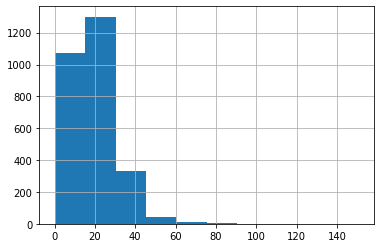

In [7]:
## 열 공급량 범위
real1['smart_farm.heat_supply'].hist()

In [8]:
real1.columns

Index(['일자', '10CM 정시 토양수분(%)', '20CM 정시 토양수분(%)', '30CM 정시 토양수분(%)',
       '50CM 정시 토양수분(%)', 'smart_farm.shield_light_h',
       'smart_farm.shield_tmperature_h', 'smart_farm.shield_energy_h',
       'smart_farm.shield_energy_v', 'smart_farm.exhaust_fan',
       'smart_farm.ceiling', 'smart_farm.floating_fan',
       'smart_farm.fan_coil_b_site',
       'smart_farm.ventilation_temperature_control',
       'smart_farm.heating_temperature_set_up', 'smart_farm.heat_supply'],
      dtype='object')

<AxesSubplot:>

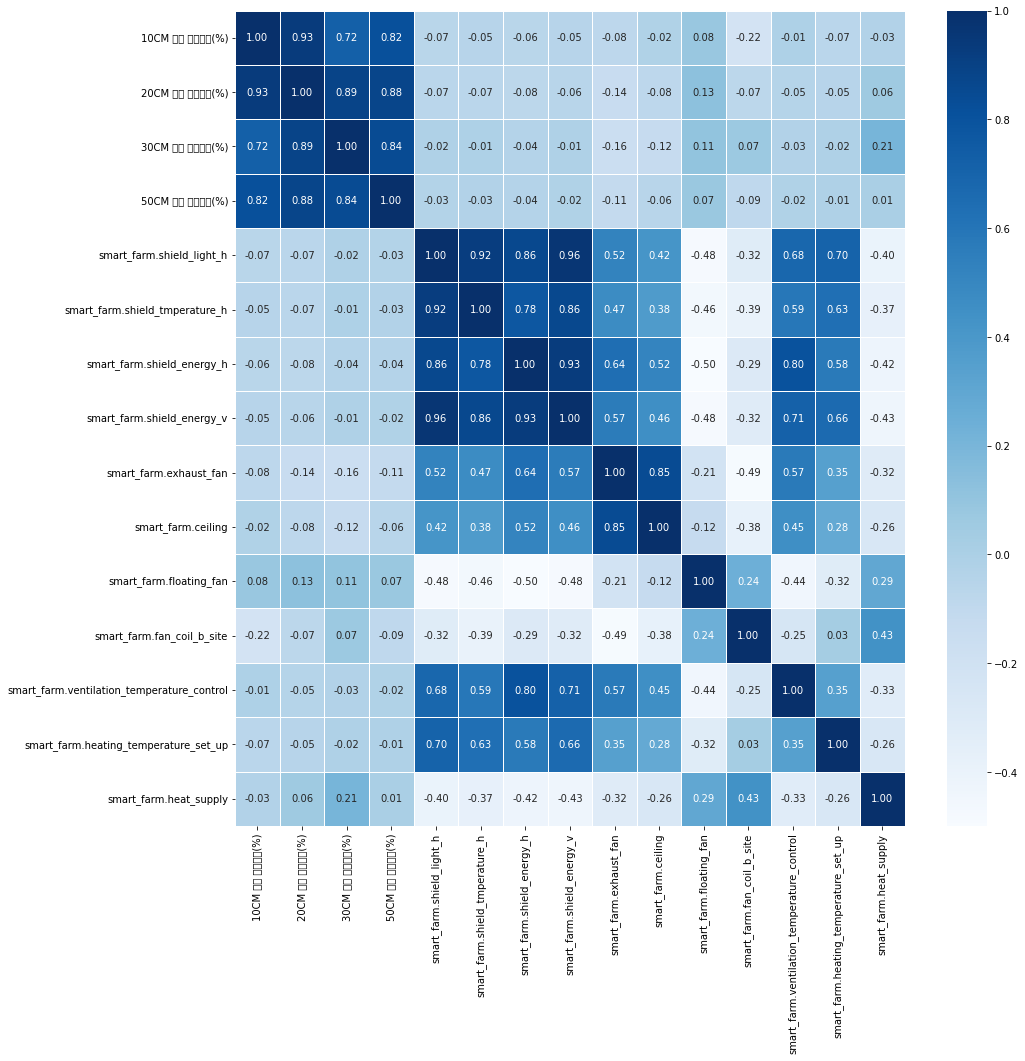

In [21]:
plt.figure(figsize=(15,15))
sns.heatmap(data = real1.corr(), annot=True, 
fmt = '.2f', linewidths=.5, cmap='Blues')

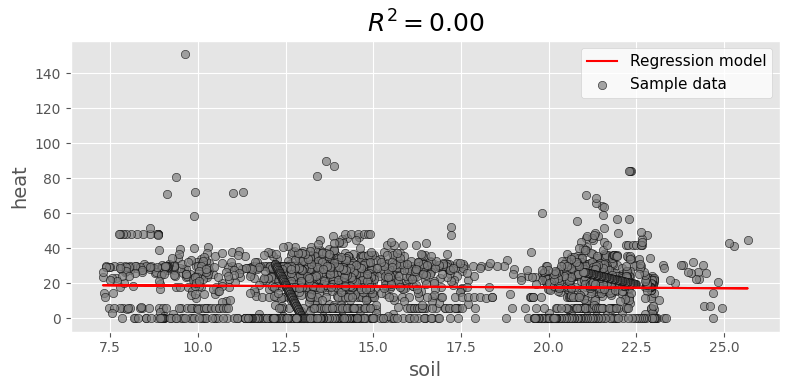

In [45]:
# 시계열이 아닌 그냥 데이터 자체로 둘의 상관관계는 전혀 없다

import pandas as pd
import matplotlib.pyplot as plt
from sklearn import linear_model

X = real1['10CM 정시 토양수분(%)'].values.reshape(-1,1)
y = real1['smart_farm.heat_supply'].values


ols = linear_model.LinearRegression()
model = ols.fit(X, y)
response = model.predict(X)


r2 = model.score(X, y)

############################################## Plot ################################################

plt.style.use('default')
plt.style.use('ggplot')

fig, ax = plt.subplots(figsize=(8, 4))

ax.plot(X, response, color='red', label='Regression model')
ax.scatter(X, y, edgecolor='k', facecolor='grey', alpha=0.7, label='Sample data')
ax.set_ylabel('heat', fontsize=14)
ax.set_xlabel('soil', fontsize=14)
# ax.text(0.8, 0.1, 'aegis4048.github.io', fontsize=13, ha='center', va='center',
#          transform=ax.transAxes, color='grey', alpha=0.5)
ax.legend(facecolor='white', fontsize=11)
ax.set_title('$R^2= %.2f$' % r2, fontsize=18)

fig.tight_layout()
# plt.savefig('reg_esr.png')

([<matplotlib.axis.YTick at 0x2626c88fa90>,
 [Text(0, 0, ''), Text(0, 0, '')])

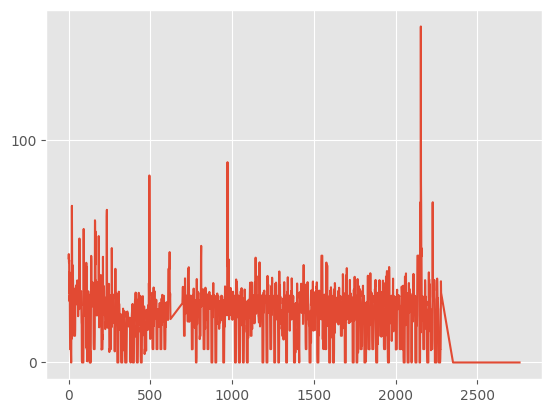

In [50]:
real1['smart_farm.heat_supply'].plot()
plt.yticks([0,100])

([<matplotlib.axis.YTick at 0x2626bc37fd0>,
 [Text(0, 0, ''), Text(0, 0, '')])

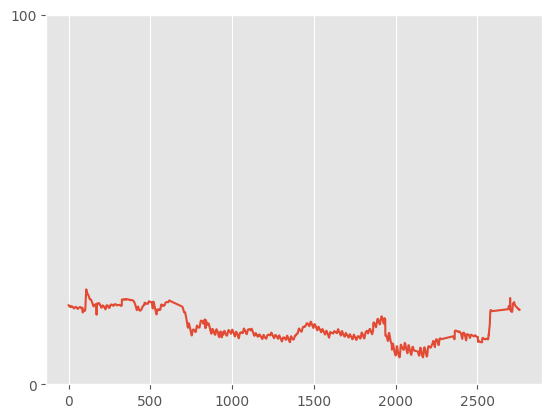

In [51]:
real1["10CM 정시 토양수분(%)"].plot()
plt.yticks([0,100])       # 다들 열 공급량과 관해 주기모양 비슷허나, 토양 수분만 조금 다름
# 위에서 열 공급량 부분 급격히 삐죽 올라간 부분 그 지점에서 soil은 가장 낮다. 고로 이러한 부분을 보완해 떨어뜨리는 기능.(관련 그림 추가)
# 다만, 이는 위에서 주기성으로 접근하는 대신에 시계열 데이터에서만 우리는 이러한 원리를 적용한다고 제한하고 감!!!

([<matplotlib.axis.YTick at 0x26269c6f790>,
 [Text(0, 0, ''), Text(0, 0, '')])

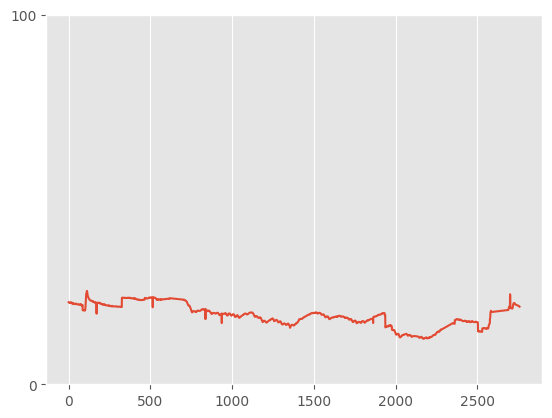

In [53]:
real1["20CM 정시 토양수분(%)"].plot()  # 토양수분끼리 생긴건 비슷함 조금 다를순있어도
plt.yticks([0,100])

In [25]:
# training = real1[:-504]
# testing = real1[-504:]
# testing = testing.reset_index()
# testing = testing.drop('index', axis=1)
# testing
# training

,일자,10CM 정시 토양수분(%),20CM 정시 토양수분(%),30CM 정시 토양수분(%),50CM 정시 토양수분(%),smart_farm.shield_light_h,smart_farm.shield_tmperature_h,smart_farm.shield_energy_h,smart_farm.shield_energy_v,smart_farm.exhaust_fan,smart_farm.ceiling,smart_farm.floating_fan,smart_farm.fan_coil_b_site,smart_farm.ventilation_temperature_control,smart_farm.heating_temperature_set_up,smart_farm.heat_supply
0,2021-11-26 0:00,21.400000,22.190909,21.800000,24.372727,0.0,0.000000,0.0,0.0,0.0,0.0,1.0,0.600000,28.0,18.000000,46.8
1,2021-11-26 1:00,21.327273,22.172727,21.900000,24.381818,0.0,0.000000,0.0,0.0,0.0,0.0,1.0,0.650000,28.0,18.000000,48.7
2,2021-11-26 2:00,21.281818,22.127273,21.745455,24.372727,0.0,0.000000,0.0,0.0,0.0,0.0,1.0,0.683333,28.0,18.000000,45.0
3,2021-11-26 3:00,21.227273,22.109091,21.718182,24.372727,0.0,0.000000,0.0,0.0,0.0,0.0,1.0,0.750000,28.0,18.000000,46.0
4,2021-11-26 4:00,21.163636,22.072727,21.700000,24.363636,0.0,0.000000,0.0,0.0,0.0,0.0,1.0,0.783333,28.0,18.000000,31.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2251,2022-02-27 19:00,12.181818,13.927273,13.500000,17.163636,0.0,58.216667,0.0,0.0,0.0,0.0,1.0,0.000000,28.0,16.716667,0.4
2252,2022-02-27 20:00,12.181818,14.018182,13.536364,17.172727,0.0,0.000000,0.0,0.0,0.0,0.0,1.0,0.166667,28.0,15.128333,13.1
2253,2022-02-27 21:00,12.145455,14.063636,13.554545,17.172727,0.0,0.000000,0.0,0.0,0.0,0.0,1.0,0.750000,28.0,15.411667,35.4
2254,2022-02-27 22:00,12.081818,14.100000,13.545455,17.181818,0.0,0.000000,0.0,0.0,0.0,0.0,1.0,0.900000,28.0,17.263333,37.4
